In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.value/100

In [3]:
from Corrfunc.mocks import DDrppi_mocks, DDtheta_mocks
from Corrfunc.io import read_catalog
from Corrfunc.theory import DDrppi, DD
from Corrfunc.utils import convert_rp_pi_counts_to_wp, convert_3d_counts_to_cf

In [4]:
cmass = np.load('../catalogue/cmass_z_cut.npy')
random = np.load('../catalogue/random_cmass.npy')

In [5]:
Nbins = 15
rp_bin = np.geomspace(3, 100, Nbins+1)

z = 1.69
h = cosmos.H0.to(u.km/u.s/u.Mpc).value / 100
d_A = cosmos.angular_diameter_distance(z).to(u.Mpc).value
chi_l = d_A*(1+z)

theta_bins = rp_bin/h/(1+z)/d_A
theta_bins_deg = np.rad2deg(theta_bins)

In [6]:
Nd = len(cmass)
Nr = len(random)

In [7]:
dd_theta = DDtheta_mocks(autocorr=1, nthreads=50, binfile=theta_bins_deg,
                         RA1=cmass['ra'], DEC1=cmass['dec'], weights1=cmass['w'])
dr_theta = DDtheta_mocks(autocorr=0, nthreads=50, binfile=theta_bins_deg, 
                         RA1=cmass['ra'], DEC1=cmass['dec'], weights1=cmass['w'],
                         RA2=random['ra'], DEC2=random['dec'], weights2=random['w'])
rr_theta = DDtheta_mocks(autocorr=1, nthreads=50, binfile=theta_bins_deg, 
                         RA1=random['ra'], DEC1=random['dec'], weights1=random['w'])

In [8]:
w_theta = convert_3d_counts_to_cf(Nd, Nd, Nr, Nr, dd_theta, dr_theta, dr_theta, rr_theta)

Text(0, 0.5, '$w(\\theta)$')

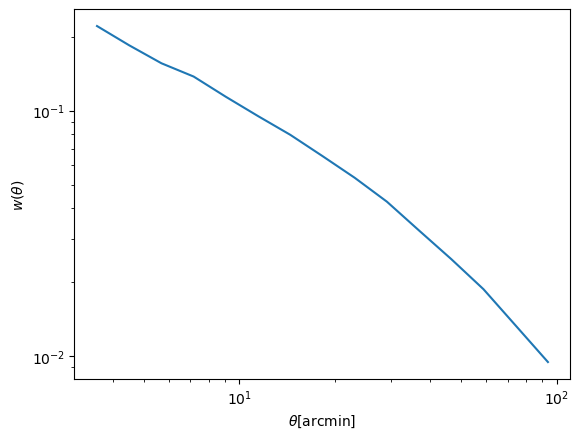

In [9]:
plt.plot((theta_bins_deg[1:]*theta_bins_deg[:-1])**0.5*60, w_theta)
plt.loglog()
plt.xlabel('$\\theta[\\mathrm{arcmin}]$')
plt.ylabel('$w(\\theta)$')

In [10]:
import healpy as hp

pixelize

In [11]:
Nside = 1024
pix = hp.ang2pix(Nside, np.radians(90 - cmass['dec']), np.radians(cmass['ra']))
cmass_pix = cmass.copy()
theta, phi = hp.pix2ang(Nside, pix)
cmass_pix['ra'] = np.rad2deg(phi)
cmass_pix['dec'] = 90 - np.rad2deg(theta)

In [12]:
pix = hp.ang2pix(Nside, np.radians(90 - random['dec']), np.radians(random['ra']))
random_pix = random.copy()
theta, phi = hp.pix2ang(Nside, pix)
random_pix['ra'] = np.rad2deg(phi)
random_pix['dec'] = 90 - np.rad2deg(theta)

In [13]:
dd_theta = DDtheta_mocks(autocorr=0, nthreads=50, binfile=theta_bins_deg,
                         RA1=cmass_pix['ra'], DEC1=cmass_pix['dec'], weights1=cmass_pix['w'],
                         RA2=cmass['ra'], DEC2=cmass['dec'], weights2=cmass['w'])
d1r2_theta = DDtheta_mocks(autocorr=0, nthreads=50, binfile=theta_bins_deg, 
                         RA1=cmass['ra'], DEC1=cmass['dec'], weights1=cmass['w'],
                         RA2=random_pix['ra'], DEC2=random_pix['dec'], weights2=random_pix['w'])
d2r1_theta = DDtheta_mocks(autocorr=0, nthreads=50, binfile=theta_bins_deg, 
                         RA1=cmass_pix['ra'], DEC1=cmass_pix['dec'], weights1=cmass_pix['w'],
                         RA2=random['ra'], DEC2=random['dec'], weights2=random['w'])
rr_theta = DDtheta_mocks(autocorr=1, nthreads=50, binfile=theta_bins_deg, 
                         RA1=random_pix['ra'], DEC1=random_pix['dec'], weights1=random_pix['w'],
                         RA2=random['ra'], DEC2=random['dec'], weights2=random['w'])

In [14]:
w_theta_pix = convert_3d_counts_to_cf(Nd, Nd, Nr, Nr, dd_theta, d1r2_theta, d2r1_theta, rr_theta)

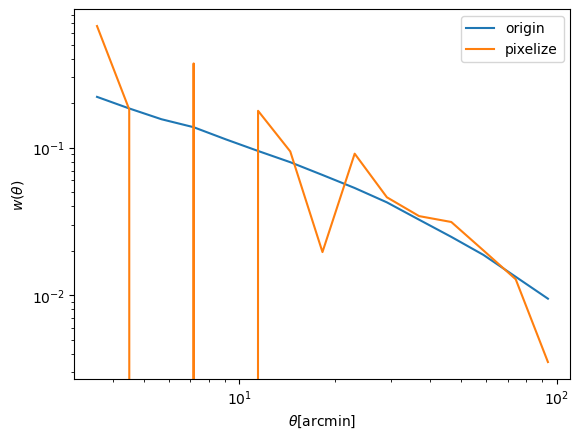

In [15]:
plt.plot((theta_bins_deg[1:]*theta_bins_deg[:-1])**0.5*60, w_theta, label='origin')
plt.plot((theta_bins_deg[1:]*theta_bins_deg[:-1])**0.5*60, w_theta_pix, label='pixelize')
plt.loglog()
plt.xlabel('$\\theta[\\mathrm{arcmin}]$')
plt.ylabel('$w(\\theta)$')
plt.legend()
plt.show()